# Bayesian Optimization

Bayesian optimization is a powerful tool used for optimization tasks such as hyperparameter tuning or searching for top performers within a design space. Traditional design of experiment when using grid or even random search breaks down when the number of parameters you're exploring becomes large. On the other hand, Bayesian Optimization builds a probabilistic model, called a surrogate model, and uses it along with an acquisition function to select the most promising combination of parameters. 

In this notebook we will be using GPyTorch alongside BoTorch to build a Bayesian Optimization model using a Gaussian Process. Despite sklearn having built in functions to do this, we will be implementing it by scratch in order to demonstrate how each part works.

GPyTorch is a library built to create Gaussain Process based Bayesian Optimization models. GPyTorch is really good at handling large datasets and more complex models. It provides not only out of the box functions for quick and easy implementation but includes frameworks that can be used to customize the models.

BoTorch is a library made for Bayesian Optimization built on GPyTorch. The goal of BoTorch is to create easy and accessible methods for implementing a Bayesian Optimization model. 

Below are the docs for both:

**GPyTorch:** https://docs.gpytorch.ai/en/stable/

**BoTorch:** https://botorch.org/docs/introduction

### Video

https://www.youtube.com/watch?v=qVEBO1Viv7k&list=PLL0SWcFqypCl4lrzk1dMWwTUrzQZFt7y0&index=39 (Bayesian Optimization)

## Setup

In [500]:
import torch 
import random 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gpytorch 
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

warnings.simplefilter("ignore")

# ensure seeds are set for reproducibility
def set_seeds(seed):
    """set all library random seeds"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seeds(0)

### Objective Function

Starting off we are going to perform Bayesian Optimization on a 2D function. Starting with a low dimensional implementation of any model is smart as it is easily visualizable. This lets you double check that everything is working right before you apply it to high dimensional datasets. Although there are ways to remap high dimensional data to a 2 or 3 dimensional graph, it is significantly harder to interpret.

We will create a nice smooth function (with a little bit of noise as real_std) with a clear maximum. We will use 100 data points to keep things small and easy to see. 

We will also need to convert the data to torch tensors to be compatible with the bayesian optimization botorch models. In essence, tensors are high dimensional matrices. A vector is a 1D tensor, a matrix is a 2D tensor, and so on. They have a large amount of supported data manipulation that can be done and are very useful when dealing with datasets. Additionally, Torch tensors are designed for efficient computation for machine learning tasks. 

In [501]:
set_seeds(0)

# create our synthetic data
def objective_function(X):

    # set the noise level
    real_std = 0.15

    # generate the synthetic data
    Y = np.sin(X) + 0.5 * np.sin(3 * X) + np.random.randn(*X.shape) * real_std
    Y = Y / Y.max()
    return torch.tensor(Y, dtype=torch.float32)

# generate synthetic data
Y = objective_function(X)

# standardize the data
XStand = StandardScaler()
YStand = StandardScaler()

XStand.fit(X)
YStand.fit(Y)

X = torch.tensor(XStand.fit_transform(X))
Y = torch.tensor(YStand.fit_transform(Y.reshape(-1, 1)))

To start, let's visualize this data. 

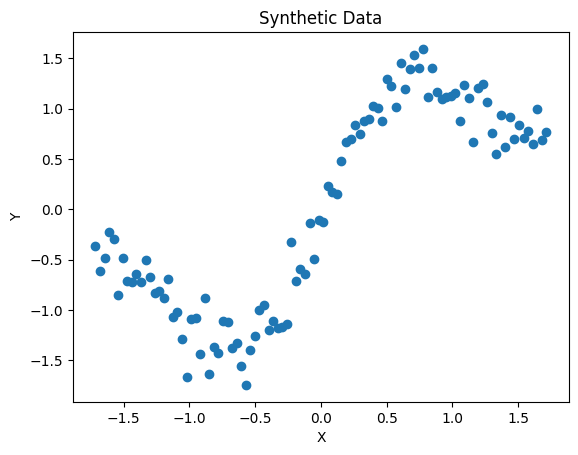

In [502]:
# plot the data
plt.scatter(X, Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Data')
plt.show()

### Set Up The Model 

SkLearn offers a one line soluytion to generating a model, but in order to show you what's going on here we will build it by hand.

We will create our GaussianProcess from the SingleTaskGP. The SingleTaskGP is a BoTorch method made for models that are trying to predict a single task. This fits what we are trying to do so we will use it. 

### Initialization

Next we need to initialize the model with the training data as well as create a likelihood function. The first line sets up the structure of the GP model and passes the training data and likelihood function into it. The ConstantMean() function assumes that there is a constant mean across the input space. Next, we will choose what kernel to use. This is something that depends on what data you're trying to use and how it is shaped. 

##### Kernels for Bayesian Optimization

The two most common kernels used in Bayesian Optimization are the Radial Basis Function (RBF) and the Matern Kernel.

**Radial Basis Function (RBF)**:

Strengths
- Assumes the function being modeled is smooth and infinitely differentiable
- It can model any continuous function given enough data

Weaknesses
- Real world functions are often not totally smooth, this leads to assumptions that are oversimplified

**Matern**:

Strengths
- Flexible due to ability to adjust a smoothness parameter
- Does not assume infinite differentiability which can represent real world functions better 

Weaknesses 
- Smoothness parameter introduces something that needs to be tuned to the data as the initial guess might not be accurate 

Lastly, the ScaleKernel() function scales the output of the kernel by a learnable factor. This scale can adjust the variance of the Gaussian Process to better fit the data. 

### Forward Step

The forward step calculates the mean and covariance of the input points in order to create a multivariate normal distribution of the Gaussian Process's predictions. 

In [503]:
class GaussianProcess(SingleTaskGP):
    def __init__(self, x_train, y_train):

        # define the mean and covariance functions
        super(GaussianProcess, self).__init__(x_train, y_train)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1))

    # define the forward method
    def forward(self, x):
        # calculate the mean and covariance of the Gaussian process at the input x and return a Multivariate Normal
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Next we will set up our acquisition function. The acquisition function takes the outputted multivariate normal distribution from the Gaussain Process and determines which point is the next best candidate. The advantage of using an acquisition function is that it balances exploration and exploitation. The exploration controls how much the model will sample points in unexplored input space, and the exploitation controls how much the model samples points next to already high performing points.

### Types of Acquisition Functions

The three most common acquisition functions are Probability of Improvement (PI), Upper Confidence Bound (UCB), and Expected Improvement (EI). These acquisition functions can be combined and customized to fit the needs of the model you're building. In this notebook however, we will talk about the common 3 choices. 

#### Probability of Improvement (PI)

##### Formula: 
$PI(x) = P(f(x)\ge f_{best}+\varepsilon)$

Strengths
- Simple and interpretable 
- Focuses on regions with high performing samples 

Weaknesses
- Can be overly exploitive and get stuck in areas with the current best performing samples

In [504]:
def ProbabilityOfImprovement(model, X, Yc, epsilon=0.01):

    set_seeds(0)

    with torch.no_grad():
        # calculate the mean and standard deviation of the posterior
        posterior = model(X)
        mean = posterior.mean
        std = posterior.variance.sqrt()

        # avoid division by zero just in case
        std = torch.clamp(std, min=1e-9)

        # calculate the probability of improvement
        f_max = Yc.max()
        Z = (mean - f_max - epsilon) / std
        normal = torch.distributions.Normal(0, 1)
        pi = normal.cdf(Z)
        
    return pi

#### Upper Confidence Bound (UCB)

The UCB balances exploration and exploitation by using the mean prediction and uncertainty values. The $\kappa$ controls the trade-off of exploration and exploitation. A higher $\kappa$ value will result in more exploration and vice versa.

##### Formula

$UCB(x) = \mu (x) + \kappa \sigma (x)$

Strengths
- Balances exploration and exploitation well 
- Finds samples in uncertain regions

Weaknesses
- Requires tuning of the $\kappa$ parameter 

In [505]:
def UpperConfidenceBound(model, X, kappa=2.0):

    set_seeds(0)
    
    # calculate the upper confidence bound
    with torch.no_grad():
        # calculate the mean and standard deviation of the posterior
        posterior = model(X)
        mean = posterior.mean
        std = posterior.variance.sqrt()

        ucb = mean + kappa * std
        
    return ucb

#### Expected Improvement (EI)

Expected improvement measures the expected amount of improvement over the current best sample. This is a very popular choice as it does an excellent job at balancing exploration and exploitation. 

##### Formula 

$EI(x) = E[max(0, f(x)-f_{best})]$

Strengths
- Balances exploration and exploitation effectively 
- Provides a clear improvement value for each point

Weaknesses
- More computationally intensive than the other acquisition functions due to the expected improvement calculations

In [506]:
def ExpectedImprovement(model, X, Yc, xi=0.01):

    set_seeds(0)

    with torch.no_grad():

        # calculate the mean and standard deviation of the posterior
        posterior = model(X)
        mean = posterior.mean
        std = posterior.variance.sqrt()

        # avoid division by zero
        std = torch.clamp(std, min=1e-9)

        # calculate the expected improvement
        f_max = Yc.max()
        Z = (mean - f_max - xi) / std
        normal = torch.distributions.Normal(0, 1)
        ei = std * (Z * normal.cdf(Z) + normal.log_prob(Z).exp())

    return ei

Lastly we will create the bayesian optimization loop. This takes the surrogate model and acquisition function, and puts them together into a combined optimization process. We will be sampling from the existing synthetic dataset and we will be finding the maximum points in the dataset using our predefined models. Each time we sample from the dataset we will remove that point from the possible acquisition function values to ensure we don't accidentally resample any points. Play around with the initial points and iterations to see how the results change!


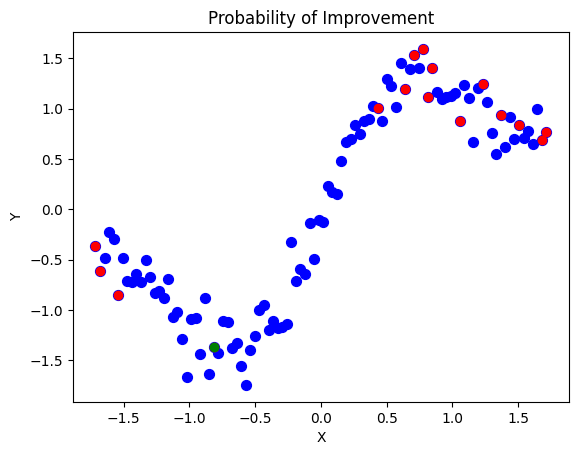

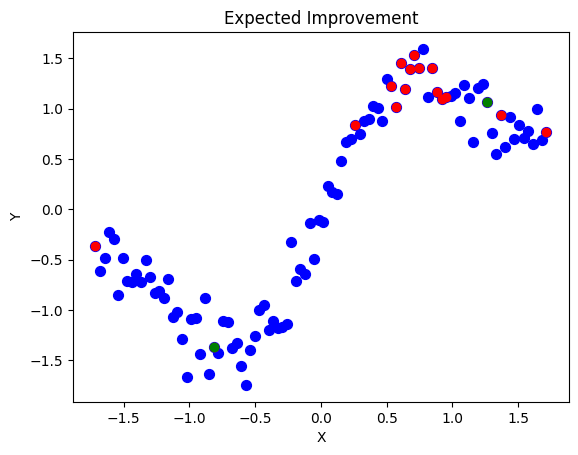

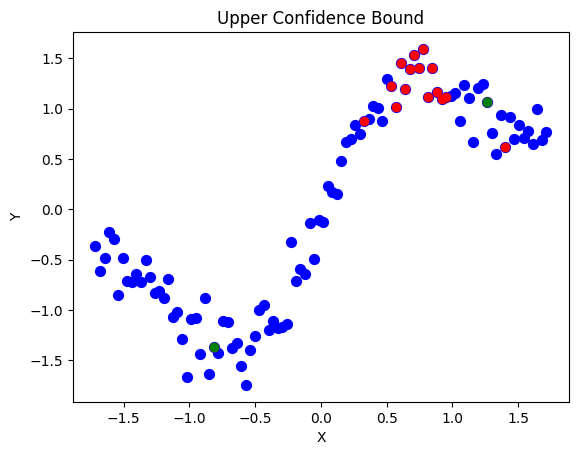

In [507]:
# set the number of iterations
iterations = 15

# set the number of initial points
intial_points = 1

# set the random seed 
set_seeds(0)

# randomly sample the initial points and create our training data
idx = np.random.choice(range(len(X)), intial_points, replace=False)
initialPoints = X.clone()[idx]
initialPointsY = Y.clone()[idx]

x_train = X.clone()[idx]
y_train = Y.clone()[idx]

# run Bayesian Optimization with Probability of Improvement
for i in range(iterations):


    # standardize the data
    x_train = torch.tensor(XStand.transform(x_train))
    y_train = torch.tensor(YStand.transform(y_train))

    # build the model with our training data (because the training data is updated we do this with each pass-through)
    model = GaussianProcess(x_train, y_train)

    # calculate the marginal log likelihood
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # fit the model
    fit_gpytorch_mll(mll)

    # evaluate the model
    model.eval()

    # make predictions with the model
    with torch.no_grad():
        pred = model(torch.tensor(XStand.transform(X)))

    # calculate the acquisition function values by passing the prediction values through the acquisition function
    acqVals = ProbabilityOfImprovement(model, X, y_train)

    # remove the already sampled points from the acquisition function values to prevent resampling
    acqVals[idx] = -1000

    # find the next index to sample by finding the point with the highest acquisition function value
    next_idx = acqVals.argmax()

    # add the next point to the training data
    idx = np.append(idx, next_idx)

    # update the training data
    x_train = X.clone()[idx]
    y_train = Y.clone()[idx]

# plot the data for Probability of Improvement
plt.scatter(X, Y, color='blue', label='Data Points', s=50)
plt.scatter(x_train, y_train, color='red', label='Observed Values')
plt.scatter(initialPoints, initialPointsY, color='green', label='Initial Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Probability of Improvement')
plt.show()


# reset the data for Expected Improvement
idx = np.random.choice(range(len(X)), initial_points, replace=False)
initialPoints = X.clone()[idx]
initialPointsY = Y.clone()[idx]
x_train = X.clone()[idx]
y_train = Y.clone()[idx]

# run Bayesian Optimization with Expected Improvement
for i in range(iterations):

    # standardize the data
    x_train = torch.tensor(XStand.transform(x_train))
    y_train = torch.tensor(YStand.transform(y_train))

    # build the model with our training data (because the training data is updated we do this with each pass-through)
    model = GaussianProcess(x_train, y_train)

    # calculate the marginal log likelihood
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # fit the model
    fit_gpytorch_mll(mll)

    # make predictions with the model
    with torch.no_grad():
        pred = model(torch.tensor(XStand.transform(X)))

    # calculate the acquisition function values by passing the prediction values through the acquisition function
    acqVals = ExpectedImprovement(model, X, y_train)

    # remove the already sampled points from the acquisition function values to prevent resampling
    acqVals[idx] = -1000

    # find the next index to sample by finding the point with the highest acquisition function value
    next_idx = acqVals.argmax()

    # add the next point to the training data
    idx = np.append(idx, next_idx)

    # update the training data
    x_train = X.clone()[idx]
    y_train = Y.clone()[idx]

# plot the data for Expected Improvement
plt.scatter(X, Y, color='blue', label='Data Points', s=50)
plt.scatter(x_train, y_train, color='red', label='Observed Values')
plt.scatter(initialPoints, initialPointsY, color='green', label='Initial Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Expected Improvement')
plt.show()

# reset the data for Upper Confidence Bound
idx = np.random.choice(range(len(X)), initial_points, replace=False)
initialPoints = X.clone()[idx]
initialPointsY = Y.clone()[idx]
x_train = X.clone()[idx]
y_train = Y.clone()[idx]
    
# run Bayesian Optimization with Upper Confidence Bound
for i in range(iterations):

    # standardize the data
    x_train = torch.tensor(XStand.transform(x_train))
    y_train = torch.tensor(YStand.transform(y_train))

    # build the model with our training data (because the training data is updated we do this with each pass-through)
    model = GaussianProcess(x_train, y_train)

    # calculate the marginal log likelihood
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # fit the model
    fit_gpytorch_mll(mll)

    # make predictions with the model
    with torch.no_grad():
        pred = model(torch.tensor(XStand.transform(X)))

    # calculate the acquisition function values by passing the prediction values through the acquisition function
    acqVals = UpperConfidenceBound(model, X, kappa=2.0)

    # remove the already sampled points from the acquisition function values to prevent resampling
    acqVals[idx] = -1000

    # find the next index to sample by finding the point with the highest acquisition function value
    next_idx = acqVals.argmax()

    # add the next point to the training data
    idx = np.append(idx, next_idx)

    # update the training data
    x_train = X.clone()[idx]
    y_train = Y.clone()[idx]

# Plot the data for Upper Confidence Bound
plt.scatter(X, Y, color='blue', label='Data Points', s=50)
plt.scatter(x_train, y_train, color='red', label='Observed Values')
plt.scatter(initialPoints, initialPointsY, color='green', label='Initial Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Upper Confidence Bound')
plt.show()


As you can see here, the Upper Confidence Bounds and the Expected Improvement acquisition functions perform pretty similarly. They both do a good job at finding the general maximum points of the dataset. The Probability of Improvement has a hard time finding points away from the initial sampled point but finds some high performing points eventually. 